This booklet serves as a more convenient testing bed for the predictor model as jupyter notebooks allow code to be run section by section meaning that

Import Libraries

In [ ]:
import os
import jax
import jax.numpy as jnp
import jax.nn as jnn
import flax.nnx as nnx
from flax import struct
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Any
import jraph
from itertools import combinations
import meshio
import numpy as np
from dataclasses import dataclass
from ProjectUtils import mean_and_std_dev, scale_data, unscale_data, Get_known, build_graphs, build_send_receive
from Predictor_Model import GNN

Hyper Params

In [30]:
Epochs = 500
alpha = 1.0 ; gamma = 1.0 ; lambda_ = 1.0
beta_1 = 0.9 ; beta_2 = 0.999
batch_size = 10
train_split = 0.8 ; CV_split = 0.1 ; test_split = 0.1
Learn_Rate = 0.001

RNG key

In [31]:
seed = 42 # This can be changed but is here to make the results easy to reproduce
base_key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(base_key)

import data

In [33]:
# Define the path to your result file
filepath = os.path.join('data', 'vtk', 'u_final.vtu')

if not os.path.exists(filepath):
    print(f"Error: '{filepath}' not found. Please check the file path.")
else:
    mesh = meshio.read(filepath)

    positions = mesh.points
    right_face_indices = np.where(np.isclose(positions[:, 0], 1.0))[0]
    element_connectivity = mesh.cells[0].data

    unique_edges = set()

    for element in element_connectivity:
        element_senders, element_receivers = build_send_receive(element)
        
        for i in range(len(element_senders)):
            edge = tuple(sorted((element_senders[i], element_receivers[i])))
            unique_edges.add(edge)

    edge_list = jnp.array(list(unique_edges))
    senders = edge_list[:, 0]
    receivers = edge_list[:, 1]


    print("Data extraction complete.\n")
    print(f"Positions array shape: {positions.shape}")
    print(f"Senders array shape: {senders.shape}")
    print(f"Receivers array shape: {receivers.shape}")

Data extraction complete.

Positions array shape: (1000, 3)
Senders array shape: (10476,)
Receivers array shape: (10476,)


Unpickling the data

In [34]:
import sys
import types
import pickle

fake_module = types.ModuleType("DataSetup")

class DataStore:
    def __init__(self):
        pass

fake_module.DataStore = DataStore

sys.modules["DataSetup"] = fake_module

data_file = r"/home/samuel/Github/Research-Placement/data/simulation_results.pkl"

try:
    with open(data_file, "rb") as f:
        data_unpickled_1 = pickle.load(f)
    print(f"Successfully unpickled data.")
except FileNotFoundError:
    print(f"Error: File not found at {data_file}")
    dataset_list = {}

dataset_dict = data_unpickled_1

# Not tunable, is known from how many sims ran
num_sims = 1000
# permutation list for batching
index_list = jnp.arange(num_sims)
permutated_index_list = jax.random.permutation(jax.random.PRNGKey(0), index_list)

Successfully unpickled data.


Data pre-processing and graph building

In [36]:
# Pre-processing
boundary_nodes = jnp.array(list(dataset_dict[0]['boundary_strain_energy_gradient'].keys()), dtype=jnp.int32)
processed_dataset_dict = dataset_dict

graphs_list = []
displacements_list = []
target_e_list = []
target_e_prime_list = []
boundary_displacements_list = []

num_nodes = positions.shape[0]

for i in tqdm(range(num_sims), leave=False):
    sim_entry = processed_dataset_dict[i]

    U_full = jnp.array(sim_entry['full_displacement_vector']).reshape(num_nodes,3)
    displacements_list.append(U_full)

    disp_map = sim_entry['applied_boundary_displacements']
    disp_vals = jnp.stack([jnp.array(disp_map[int(k)]) for k in boundary_nodes])  
    boundary_displacements_list.append(disp_vals)

    grad_map = sim_entry['boundary_strain_energy_gradient']
    grad_vals = jnp.stack([jnp.array(grad_map[int(k)]) for k in boundary_nodes])  
    target_e_prime_list.append(grad_vals)

    target_e = jnp.array(sim_entry['strain_energy'])
    target_e_list.append(target_e)

displacements_list = jnp.stack(displacements_list, axis=0)
boundary_displacements_list = jnp.stack(boundary_displacements_list, axis=0)
target_e_list = jnp.stack(target_e_list, axis=0)
target_e_prime_list = jnp.stack(target_e_prime_list, axis=0)

displacement_params = mean_and_std_dev(boundary_displacements_list, train_split=train_split, permutated_idxs=permutated_index_list)

e_params = mean_and_std_dev(target_e_list, train_split=train_split, permutated_idxs=permutated_index_list)
target_e_list_scaled = scale_data(target_e_list, data_params=e_params)

e_prime_params = mean_and_std_dev(target_e_prime_list, train_split=train_split, permutated_idxs=permutated_index_list)
target_e_prime_list_scaled = scale_data(target_e_prime_list, data_params=e_prime_params)

params_dict = {
    'displacements': displacement_params,
    'energy': e_params,
    'grad': e_prime_params
}

dataset = {
    'displacements': displacements_list,
    'target_e': target_e_list_scaled,
    'target_e_prime': target_e_prime_list_scaled,
    'boundary_displacements': boundary_displacements_list,
    'boundary_nodes_indices': boundary_nodes
}

Batching functions

In [37]:
def batch_and_split_dataset(dataset_dict, batch_size, train_split, CV_split, test_split, permutated_index_list):
    total_samples = permutated_index_list.shape[0]
    idx_train_samples = int(train_split * total_samples) 
    idx_test_samples = idx_train_samples + int(test_split * total_samples) 

    train_idx = list(permutated_index_list[:idx_train_samples])
    test_idx = list(permutated_index_list[idx_train_samples:idx_test_samples])
    CV_idx = list(permutated_index_list[idx_test_samples:])

    def batch_indices(idx):  
        if not idx:
            return
        num_samples = len(idx)
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            batch_idx = idx[start:end]
            
            displacements_batch = [dataset_dict['displacements'][i] for i in batch_idx]
            e_batch = [dataset_dict['target_e'][i] for i in batch_idx]
            e_prime_batch = [dataset_dict['target_e_prime'][i] for i in batch_idx]
            bd_batch = [dataset_dict['boundary_displacements'][i] for i in batch_idx]

            batched_displacements = jnp.array(displacements_batch)
            batched_e = jnp.array(e_batch)
            batched_e_prime = jnp.array(e_prime_batch)
            batched_bd = jnp.array(bd_batch)

            yield {
                'displacements': batched_displacements, 
                'target_e': batched_e, 
                'target_e_prime': batched_e_prime,
                'boundary_displacements': batched_bd
            }
    
    train_batches = list(batch_indices(train_idx))
    test_batches = list(batch_indices(test_idx))
    CV_batches = list(batch_indices(CV_idx))

    return train_batches, CV_batches, test_batches


Batching graphs

In [ ]:
train_batches, CV_batches, test_batches = batch_and_split_dataset(
    dataset, 
    batch_size, 
    train_split, 
    CV_split, 
    test_split, 
    permutated_index_list
)

is_known_zero = Get_known(boundary_nodes, positions)
is_known_zero_expanded = jnp.expand_dims(is_known_zero, axis=1)
U_zero = jnp.zeros_like(positions)
node_features_zero = jnp.concatenate([positions, U_zero, is_known_zero_expanded], axis=1)

zero_graph = jraph.GraphsTuple(
    nodes=node_features_zero,
    senders=senders,
    receivers=receivers,
    edges=None,
    globals=None, 
    n_node=jnp.array([positions.shape[0]]),
    n_edge=jnp.array([len(senders)])
)

zero_list = [zero_graph for _ in range(batch_size)]
batched_zero_graph = zero_list

Loss function and Optimiser

In [43]:
def loss_fn(graph_batch, batch_targets, batched_zero_graph,*, Model, alpha, gamma, lam): 
    """
    Calculates the loss of a model, works to minimise the mean square error of both 
    the strain energy prediction and the strain energy derivative prediction,
    whilst forcing the function through zero.
    """
    target_e_batch = batch_targets['target_e']
    target_e_prime_batch = batch_targets['target_e_prime']
    
    prediction_e, prediction_e_prime = Model(graph_batch)
    loss_e = jnp.mean((prediction_e - target_e_batch)**2)
    loss_e_prime = jnp.mean((prediction_e_prime - target_e_prime_batch)**2)
    
    prediction_zero, _ = Model(batched_zero_graph)
    target_zero = (0.0 - Model.e_mean) / Model.e_std
    loss_zero = jnp.mean((prediction_zero - target_zero)**2)

    return (alpha * loss_e + gamma * loss_e_prime + lam * loss_zero)

CV loss

In [ ]:
def CV_loss_fn(CV_batches, dataset, batched_zero_graph, batch_size, Model: GNN, alpha, gamma, lambda_):
    CV_loss = 0
    batch_count = 0
    boundary_node_indicies = dataset['boundary_nodes_indices']

    for CV_batch in CV_batches:
        base_nodes = batched_zero_graph[0].nodes
        nodes_batch = jnp.broadcast_to(base_nodes, (batch_size,)+base_nodes.shape)
        bd = CV_batch['boundary_displacements']
        nodes_batch = nodes_batch.at[:, boundary_node_indicies, 3:6].set(bd)
        base_graph = batched_zero_graph[0]
        CV_graph_batch = [base_graph._replace(nodes=nodes_batch[i]) for i in range(batch_size)]

        batch_count += 1

        loss = loss_fn(
            CV_graph_batch,
            CV_batch,
            batched_zero_graph,
            Model=Model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_
        )

        CV_loss += loss

    if batch_count > 0:
        ret = CV_loss / batch_count
        return ret
    else:
        return 0

Train Step

In [45]:
@nnx.jit
def train_step(Model, optimiser, graph_batch, Target_batch, batched_zero_graph, *, alpha, gamma, lambda_):

    def wrapped_loss(Model):
        loss = loss_fn(
            graph_batch,
            Target_batch,
            batched_zero_graph,
            Model=Model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_ 
        )
        return loss
    
    loss, grads = nnx.value_and_grad(wrapped_loss, argnums=0)(Model)
    optimiser.update(Model, grads)
    return loss

Train Loop

In [46]:
Model = GNN(
    node_feature_dim=7, 
    embedding_dim=128,
    output_dim=1,
    pooling_block_dims_1=(5,5,5),
    boundary_nodes=dataset['boundary_nodes_indices'],
    base_graph=zero_graph,
    disp_mean=params_dict['displacements']['mean'],
    disp_std=params_dict['displacements']['std_dev'],
    e_mean=params_dict['energy']['mean'],
    e_std=params_dict['energy']['std_dev'],
    grad_mean=params_dict['grad']['mean'], 
    grad_std=params_dict['grad']['std_dev'],
    rngs=rngs
)

optimiser = nnx.Optimizer(
    Model,
    optax.adam(
        learning_rate=Learn_Rate, 
        b1=beta_1, 
        b2=beta_2
    ),
    wrt=nnx.Param
)

loss_record = []
CV_loss_record = []

for epoch in range(Epochs):
    running_loss = 0.0
    batch_count = 0
    for batch in tqdm(train_batches, desc=f"Epoch {epoch}/{Epochs}", leave=True):
        base_nodes = batched_zero_graph[0].nodes
        nodes_batch = jnp.broadcast_to(base_nodes, (batch_size,)+base_nodes.shape)
        bd = batch['boundary_displacements']
        nodes_batch = nodes_batch.at[:, dataset['boundary_nodes_indices'], 3:6].set(bd)
        base_graph = batched_zero_graph[0]
        graph_batch = [base_graph._replace(nodes=nodes_batch[i]) for i in range(batch_size)]

        batch_loss = train_step(
            Model,
            optimiser,
            graph_batch,
            batch,
            batched_zero_graph,
            alpha=alpha,
            gamma=gamma,
            lambda_=lambda_
        )

        batch_count += 1
        running_loss += batch_loss

    CV_loss = CV_loss_fn(
        CV_batches,
        batched_zero_graph,
        Model,
        alpha,
        gamma,
        lambda_
    )
    
    avg_loss = running_loss / batch_count if batch_count > 0 else 0.0
    loss_record.append(avg_loss)
    CV_loss_record.append(CV_loss)


Epoch 499/500: 100%|██████████| 80/80 [00:06<00:00, 13.20it/s]


plot

3.6709473


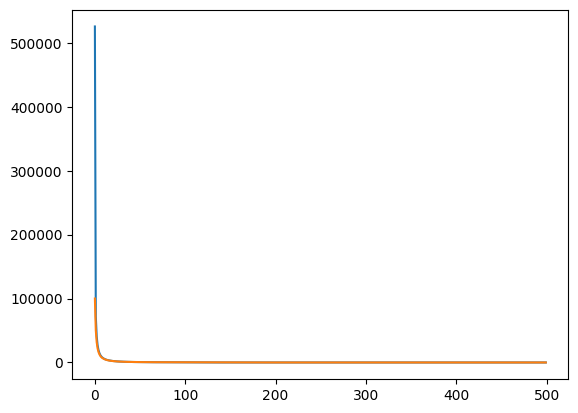

In [55]:
plt.plot(loss_record)
plt.plot(CV_loss_record)
print(CV_loss_record[-1])

Testing

In [ ]:
e_zero_test_s, e_prime_zero_test_s = Model([zero_graph])
e_us, e_pus = Model.unscale_predictions(e_zero_test_s, e_prime_zero_test_s)

[-6.448198e-05]
[[[ 11.353983  -19.758389  -28.722597 ]
  [ -9.983745    8.304135   17.12754  ]
  [-25.105345    0.7226685  30.025309 ]
  ...
  [ -1.2206386   0.9763081   1.7838296]
  [ -1.5815992   1.1683705   2.0086136]
  [ -1.1004313   0.7845991   1.2464634]]]
0.012488961
